<a href="https://colab.research.google.com/github/hendrikyong/CVNL_Assignment_1/blob/main/CVNL_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import nltk
from nltk.tokenize import word_tokenize
import requests
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
# get json dataset from github
url = "https://raw.githubusercontent.com/snipsco/nlu-benchmark/master/2016-12-built-in-intents/benchmark_data.json"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    print("Successfully fetched SNIPS dataset")

    # Extract intents and associated text queries
    snips_data = {}
    for domain in data["domains"]:
        for intent in domain["intents"]:
            intent_name = intent["benchmark"]["Snips"]["original_intent_name"]
            queries = [query["text"] for query in intent["queries"]]
            snips_data[intent_name] = queries

    print(f"Total intents: {len(snips_data)}")
    print("Example intent:", list(snips_data.keys())[0])
    print("Example queries:", snips_data[list(snips_data.keys())[0]][:5])
else:
    print("Failed to fetch SNIPS dataset")

Successfully fetched SNIPS dataset
Total intents: 10
Example intent: ShareCurrentLocation
Example queries: ["Share my location with Hillary's sister", 'Send my current location to my father', 'Share my current location with Jim', 'Send my location to my husband', 'Send my location']


In [3]:
all_words = [word for queries in snips_data.values() for query in queries for word in word_tokenize(query.lower())]

# build vocabulary
vocab = {word: idx + 2 for idx, word in enumerate(Counter(all_words))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

# map intent
intent_labels = {intent: idx for idx, intent in enumerate(snips_data.keys())}

def text_to_sequence(text, vocab, max_len=10):
    tokens = [vocab.get(word, vocab["<UNK>"]) for word in word_tokenize(text.lower())]
    return tokens[:max_len] + [vocab["<PAD>"]] * (max_len - len(tokens))

sample_text = "play some jazz music"
print(text_to_sequence(sample_text, vocab))


[1, 257, 212, 1, 0, 0, 0, 0, 0, 0]


In [26]:
class SNIPSDataset(torch.utils.data.Dataset):
    def __init__(self, data, vocab, intent_labels, max_len=10):
        self.data = data
        self.vocab = vocab
        self.intent_labels = intent_labels
        self.max_len = max_len
        self.samples = [(query, intent) for intent, queries in data.items() for query in queries]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text, intent = self.samples[idx]
        tokenized_text = text_to_sequence(text, self.vocab, self.max_len)
        label = self.intent_labels[intent]
        return torch.tensor(tokenized_text), torch.tensor(label)

# create dataset, split into test and evaluation
full_dataset = SNIPSDataset(snips_data, vocab, intent_labels)
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [27]:
class IntentBiRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=2, dropout=0.6):
        super(IntentBiRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x, lengths):
        x_embedded = self.embedding(x)
        x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(x_packed)

        hidden = hidden.view(self.rnn.num_layers, 2, x.size(0), self.rnn.hidden_size)
        hidden = torch.cat((hidden[-1, 0], hidden[-1, 1]), dim=1)

        return self.fc(hidden)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IntentBiRNN(len(vocab), embed_dim=64, hidden_dim=64, output_dim=len(intent_labels)).to(device)


In [40]:
from tqdm import tqdm
import torch

def train_and_validate(model, train_loader, val_loader, device, num_epochs=10, lr=0.003, weight_decay=1e-2):
    """
    Trains the model for a specified number of epochs and validates at the end.

    Parameters:
        model (torch.nn.Module): The neural network model.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        device (torch.device): GPU or CPU.
        num_epochs (int): Number of epochs to train.
        lr (float): Learning rate.
        weight_decay (float): L2 regularization factor.

    Returns:
        dict: Dictionary containing train losses, train accuracies, val loss, and val accuracy.
    """

    # Initialize optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    train_losses, train_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for texts, labels in pbar:
                texts, labels = texts.to(device), labels.to(device)
                lengths = (texts != vocab["<PAD>"]).sum(dim=1).cpu()

                optimizer.zero_grad()
                outputs = model(texts, lengths)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                correct_train += (predictions == labels).sum().item()
                total_train += labels.size(0)

                pbar.set_postfix(Loss=f"{loss.item():.4f}")

        # Store training metrics
        train_losses.append(total_train_loss / len(train_loader))
        train_accuracies.append(100.0 * correct_train / total_train)

        print(f"Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%")

    print("Training complete!")

    # Validation step (only once at the end)
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with tqdm(val_loader, desc="Validating", unit="batch") as pbar:  # Progress bar for validation
        with torch.no_grad():
            for texts, labels in pbar:
                texts, labels = texts.to(device), labels.to(device)
                lengths = (texts != vocab["<PAD>"]).sum(dim=1).cpu()

                outputs = model(texts, lengths)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                correct_val += (predictions == labels).sum().item()
                total_val += labels.size(0)

                pbar.set_postfix(Loss=f"{loss.item():.4f}")

    # Store validation metrics
    val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100.0 * correct_val / total_val

    print("\nFinal Validation Results:")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    }


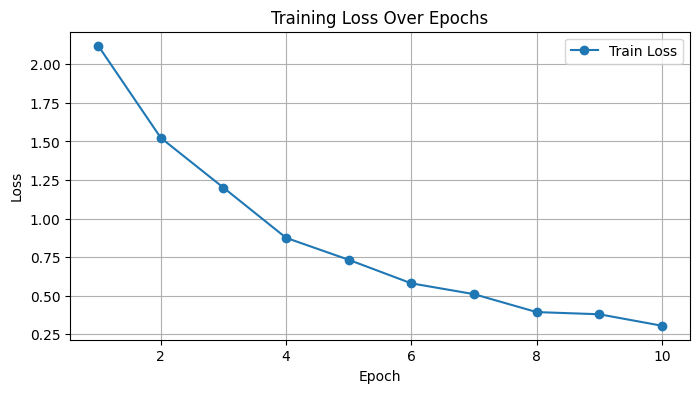

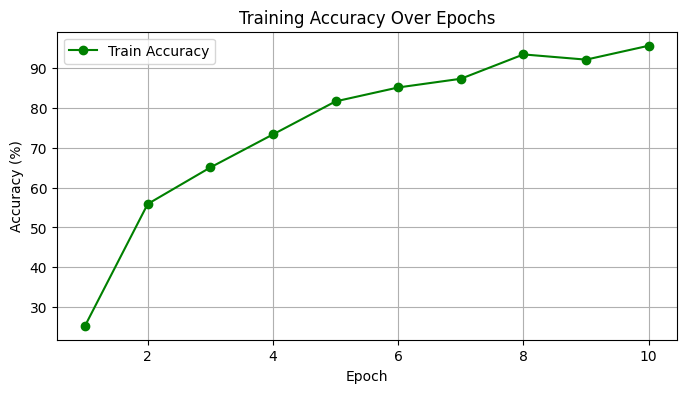

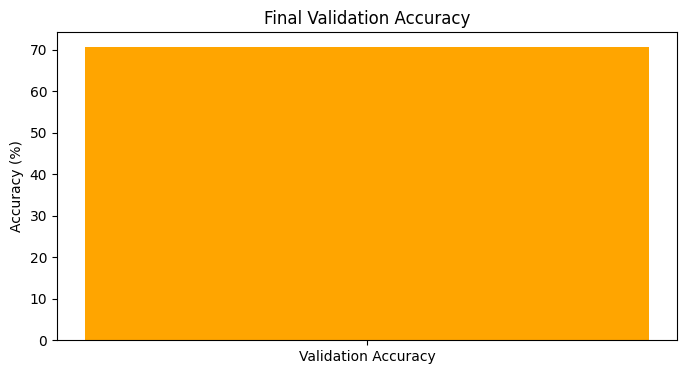

In [30]:
import matplotlib.pyplot as plt

# Plot Training Loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(8, 4))
plt.bar(["Validation Accuracy"], [val_accuracies[-1]], color="orange")
plt.ylabel("Accuracy (%)")
plt.title("Final Validation Accuracy")
plt.show()


In [31]:
def predict_intent(text, model, vocab, intent_labels):
    model.eval()

    tokenized = text_to_sequence(text, vocab)
    input_tensor = torch.tensor(tokenized).unsqueeze(0).to(device)
    length = torch.tensor([len(tokenized)], dtype=torch.int64).cpu()

    with torch.no_grad():
        output = model(input_tensor, length)
        predicted_label_idx = torch.argmax(output, dim=1).item()
    predicted_label = [key for key, value in intent_labels.items() if value == predicted_label_idx][0]
    return predicted_label

print(predict_intent("play some music", model, vocab, intent_labels))
print(predict_intent("turn on the lights", model, vocab, intent_labels))
print(predict_intent("book a flight to New York", model, vocab, intent_labels))


ComparePlaces
ComparePlaces
RequestRide


In [32]:
# Import necessary libraries
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

def generate_rnn_classification_report(model, dataloader, device, class_names):
    """
    Evaluates the RNN model using accuracy, precision, recall, and F1-score.
    """
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            lengths = (texts != vocab["<PAD>"]).sum(dim=1).cpu()  # Get actual lengths

            # Get model predictions
            outputs = model(texts, lengths)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Define class names from the SNIPS dataset
class_names = list(intent_labels.keys())

# Call the classification report function
generate_rnn_classification_report(model, val_loader, device, class_names)


Classification Report:
                       precision    recall  f1-score   support

 ShareCurrentLocation       0.60      0.60      0.60         5
        ComparePlaces       0.67      0.33      0.44         6
      GetPlaceDetails       0.71      0.50      0.59        20
          SearchPlace       0.86      0.60      0.71        10
       BookRestaurant       0.77      0.89      0.83        19
          RequestRide       0.78      0.78      0.78         9
        GetDirections       0.50      1.00      0.67         5
             ShareETA       0.75      0.75      0.75         8
GetTrafficInformation       0.62      0.83      0.71         6
           GetWeather       0.69      0.82      0.75        11

             accuracy                           0.71        99
            macro avg       0.70      0.71      0.68        99
         weighted avg       0.72      0.71      0.70        99

Accuracy: 0.7071
Precision: 0.7213
Recall: 0.7071
F1-Score: 0.6981


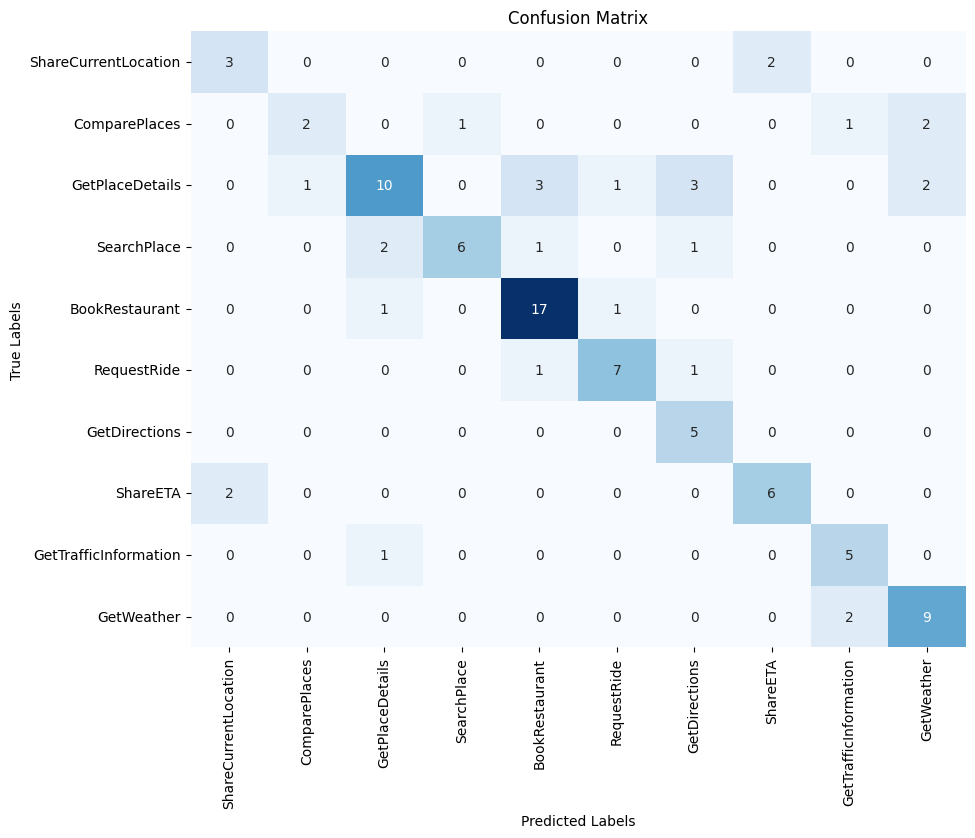

In [33]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix

def plot_rnn_confusion_matrix(model, dataloader, device, class_names):
    """
    Plots the confusion matrix to visualize misclassifications.
    """
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            lengths = (texts != vocab["<PAD>"]).sum(dim=1).cpu()  # Get actual lengths

            # Get model predictions
            outputs = model(texts, lengths)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Call the confusion matrix function
plot_rnn_confusion_matrix(model, val_loader, device, class_names)